In [1]:
AD_F = "cellSNP.tag.AD.mtx"
DP_F = "cellSNP.tag.DP.mtx"
VCF_F = "cellSNP.base.vcf"
INDIR='.'
#OUTDIR='./results/'
NUM_DONORS=2
prob_threshold=0.8

In [2]:
import os
import pandas as pd
import seaborn as sns
from glob import glob
from scipy import stats
from os.path import join


In [3]:
# if not os.path.exists(OUTDIR):
#     os.mkdir(OUTDIR)

In [4]:
# data = ["data/vireo/pseudo/numC1000_ispropFalse", 
#  "data/PBMC_J_cellSNP", "data/PBMC_P_cellSNP", '--num_cells', 1000, '--is_prop', False]

outdir = "data/vireo/pseudo/numC1000_ispropFalse"
indirs = ("data/PBMC_J_cellSNP", "data/PBMC_P_cellSNP")
num_cells_total = 2000
is_proportional = False
cell_subsample=0.1

In [5]:
# subsample_sparse_matrices(outdir, indirs,
#                           num_cells_total=num_cells,
#                           is_proportional=is_prop,
#                           cell_subsample=0.1)

In [6]:
from os.path import join
import os
from numpy import random
import numpy as np
import pandas as pd
import click
import sys

def load_mtx_df(in_f, skip_first=True, give_header=False):
    df = pd.read_csv(in_f, comment="%", header=None, sep="\t")
    df.columns = ["Variant", "Cell", "integer"]
    if skip_first:
        head = df.iloc[0]
        df = df.iloc[1:] # Seems to be summary values
    if give_header:
        return df,head
    return df



##  Merges the variant files called from cellSNP and creates the old to new map

In [7]:
""" Merges the variant files called from cellSNP

:param indirs:
:return:
"""
variants = pd.read_csv(join(indirs[0], "cellSNP.base.vcf"),
                       skiprows=1, sep="\t")
variants["old " + indirs[0]] = variants.index.values.astype(int)+1
print('variants')
print(variants.head())
print(variants.tail())
old_variants = {}
old_variants[indirs[0]] = variants.copy()
old_variants[indirs[0]].loc[:,"old"] = 0
old_variants[indirs[0]].loc[:,"old"] = old_variants[indirs[0]].index+1
#variants[indirs[0]] = variants.index.values + 1
for ind, val in enumerate(indirs[1:]):
    curr = pd.read_csv(join(val, "cellSNP.base.vcf"), skiprows=1,
                       sep="\t")
    #curr["old index"] = curr.index.values+1
    #curr[val] = curr.index.values + 1
    curr["old " + val] = curr.index.values.astype(int)+1
    variants = pd.merge(variants, curr, on=["#CHROM", "POS", "ALT"],
                        how="outer")

    print('variants')
    print(variants.head())
    print(variants.tail())
    old_variants[val] = curr.copy()
    old_variants[val]["old"] = 0 
    old_variants[val]["old"] = curr.index.values+1

variants
  #CHROM       POS ID REF ALT QUAL FILTER               INFO  \
0   chr1   2290818  .   G   C    .   PASS  AD=34;DP=34;OTH=2   
1   chr1   3624769  .   C   T    .   PASS   AD=0;DP=23;OTH=1   
2   chr1  16237293  .   G   T    .   PASS   AD=1;DP=1;OTH=19   
3   chr1  16904143  .   A   C    .   PASS   AD=1;DP=1;OTH=29   
4   chr1  21294734  .   G   A    .   PASS   AD=0;DP=90;OTH=1   

   old data/PBMC_J_cellSNP  
0                        1  
1                        2  
2                        3  
3                        4  
4                        5  
     #CHROM        POS ID REF ALT QUAL FILTER              INFO  \
1078   chrX   54639959  .   G   A    .   PASS  AD=0;DP=31;OTH=1   
1079   chrX   76173099  .   G   T    .   PASS  AD=1;DP=1;OTH=31   
1080   chrX  108091572  .   A   G    .   PASS  AD=0;DP=1;OTH=53   
1081   chrX  123960480  .   T   C    .   PASS  AD=0;DP=1;OTH=33   
1082   chrX  149939619  .   G   C    .   PASS  AD=1;DP=1;OTH=24   

      old data/PBMC_J_cellSNP

In [8]:

# Loop again and map the coordinates
vars_coords = dict()
variants["new ID"] = variants.index.values+1
full_vars = variants.copy()

# what the new index should be.
for val in indirs:
    curr_vars = pd.read_csv(join(val, "cellSNP.base.vcf"),
                            skiprows=1, sep="\t")
    curr_vars["old index"] = curr_vars.index+1
    curr_vars = pd.merge(curr_vars, full_vars, how="inner", on=["#CHROM", "POS", "ALT"])
    curr_vars.index = curr_vars["old index"]
    vars_coords[ val] = curr_vars["new ID"]  # Pandas series

if outdir is not None:
    variants.to_csv(join(outdir, "cellSNP.base.vcf"), sep='\t', index=False)
    for ind, val in enumerate(indirs):
        out_f = join(outdir, f"variant_indices_{ind}.tsv")
        vars_coords[val].index.name = val
        vars_coords[val].to_csv(out_f, sep="\t") #Use index + header

#vars_coords, variants = merge_vcf_ids(indirs, outdir=outdir)

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [9]:
vars_coords

{'data/PBMC_J_cellSNP': data/PBMC_J_cellSNP
 1          1
 2          2
 3          3
 4          4
 5          5
         ... 
 1079    1079
 1080    1080
 1081    1081
 1082    1082
 1083    1083
 Name: new ID, Length: 1083, dtype: int64,
 'data/PBMC_P_cellSNP': data/PBMC_P_cellSNP
 1       1084
 2       1085
 3       1086
 4       1087
 5       1088
         ... 
 999     1875
 1000    1876
 1001    1083
 1002    1877
 1003    1878
 Name: new ID, Length: 1003, dtype: int64}

### Get the number of cells for the proportion

In [10]:
print(outdir, indirs, cell_subsample,
                          num_cells_total,
                          is_proportional)
print(type(is_proportional))
if outdir in indirs:
    raise ValueError("Outdir is one of the indirs. This cant be. Please change one.")
# Count number of cells first
cell_count = {}
for i in indirs:
    curr_dp_f = join(i, "cellSNP.tag.DP.mtx")
    curr_ad_f = join(i, "cellSNP.tag.AD.mtx")
    curr_oth_f = join(i, "cellSNP.tag.OTH.mtx")
    dp = load_mtx_df(curr_dp_f)
    ad = load_mtx_df(curr_ad_f)
    oth = load_mtx_df(curr_oth_f)
    #cell_count[i] = len(set(dp["Cell"].values))
    cell_count[i] = len(list(set(dp["Cell"].values).union(set(ad["Cell"].values)).union(set(oth["Cell"].values))))
cell_proportion = np.array(list(cell_count.values()))/sum(cell_count.values())
print('cell proportion', cell_proportion)

# ad["Variant"] = vars_coords[ad["Variant"]]
# dp["Variant"] = vars_coords[dp["Variant"]]
# oth["Variant"] = vars_coords[oth["Variant"]]

data/vireo/pseudo/numC1000_ispropFalse ('data/PBMC_J_cellSNP', 'data/PBMC_P_cellSNP') 0.1 2000 False
<class 'bool'>
cell proportion [0.53224611 0.46775389]


### subsample each matrix and append to the lists.

In [11]:
ad_l = []
dp_l = []
oth_l = []
cells_kept = dict()
count = 0
total_cells = 0
for i in indirs:
    print('dir', i)
    ad_f = join(i, "cellSNP.tag.AD.mtx")
    dp_f = join(i, "cellSNP.tag.DP.mtx")
    oth_f = join(i, "cellSNP.tag.OTH.mtx")

    ad, ad_h = load_mtx_df(ad_f,give_header=True)
    dp, dp_h = load_mtx_df(dp_f,give_header=True)
    oth , oth_h = load_mtx_df(oth_f, give_header=True)


    #curr_cell_ids = np.sort(np.array(list(set(dp["Cell"].values).union(set(ad["Cell"].values)).union(set(oth["Cell"].values)))))
    curr_cell_ids = np.arange(1,max(max(ad_h["Cell"], dp_h["Cell"]), oth_h["Cell"])+1)
    print('curr_cell_ids', curr_cell_ids)
    curr_num_cells = len(curr_cell_ids)
    if num_cells_total is None:
        if cell_subsample != None and (cell_subsample > 0):
            # Subsample a fraction of the cells
            print('curr_num_cells', curr_num_cells)
            num_to_keep = int(round(cell_subsample*curr_num_cells))
            subs = random.choice(curr_cell_ids, replace=False, size=num_to_keep)
        else:
            raise ValueError("Either the num_cells_total or cell_subsample need to be filled")
    else:
        # Split the number of cells based on num_cells_total and fraction
        print('is_proportional', is_proportional)
        if is_proportional:
            print('here prop', cell_proportion[count])
            cells_per_sample = int(round(cell_proportion[count]*num_cells_total))
        else:
            print('non prop', num_cells_total, len(indirs))
            # Divide evenly
            cells_per_sample = int(round(num_cells_total/len(indirs)))
        if cells_per_sample > curr_num_cells:
            print("Number of cells less than the desired number. "
                  "Please consider changing a parameter. For now, "
                  "using all cells in the sample.")
            subs = curr_cell_ids
        else:
            subs = random.choice(curr_cell_ids, replace=False,
                                 size=cells_per_sample)
    
    # Filter
    ad_filt = ad[ad["Cell"].isin(subs)].copy()
    dp_filt = dp[dp["Cell"].isin(subs)].copy()
    oth_filt = oth[oth["Cell"].isin(subs)].copy()
    count += 1
    # Merge the samples together
    # Change the cell coordinates to reflect the #cells in
    # across all samples. e.g. if 2 samples, 100  of each are used,
    # then the first cell in sample 2 will have int coordinate 101
    subs = np.sort(subs)
    cell_coords_map = {val:(ind+total_cells+1) for ind, val in enumerate(subs)}
    total_cells += len(subs)
    print('subs', subs)
    print('cell coords')
    print(cell_coords_map)
    print('ad_filt')
    print(ad_filt["Cell"])
    ad_filt["Cell"] = ad_filt["Cell"].map(cell_coords_map)
    dp_filt["Cell"] = dp_filt["Cell"].map(cell_coords_map)
    oth_filt["Cell"] = oth_filt["Cell"].map(cell_coords_map)
    print('ad_filt after map')
    print(ad_filt["Cell"])
    # Change the variant coordinates as well after
    ad_filt["Variant"] = ad_filt["Variant"].map(vars_coords[i].to_dict())
    dp_filt["Variant"] = dp_filt["Variant"].map(vars_coords[i].to_dict())
    oth_filt["Variant"] = oth_filt["Variant"].map(vars_coords[i].to_dict())


    # merging with merge_vcf_ids above
    #subsample_d["cell"].append(set(cell_coords_map.values()))

    cells_kept[i] = cell_coords_map
    ad_l.append(ad_filt)
    dp_l.append(dp_filt)
    oth_l.append(oth_filt)


dir data/PBMC_J_cellSNP
curr_cell_ids [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 

In [12]:
print(ad_l[ind]["Variant"].max())
print(len(set(ad_l[ind]["Variant"])))

print(dp_l[ind]["Variant"].max())
print(len(set(dp_l[ind]["Variant"])))

print(oth_l[ind]["Variant"].max())
print(len(set(oth_l[ind]["Variant"])))


1878
526
1878
910
1878
874


In [13]:
print(ad_l[ind]["Cell"].max())
print(len(set(ad_l[ind]["Cell"])))

print(dp_l[ind]["Cell"].max())
print(len(set(dp_l[ind]["Cell"])))

print(oth_l[ind]["Cell"].max())
print(len(set(oth_l[ind]["Cell"])))


1421
584
1421
616
1421
614


### Remap the variants one more time to make it ordered 1-#variants in case some where dropped when sampling

In [14]:
(dp_l[0]["Cell"] < 501).all()

False

In [15]:
max(dp_l[0]["Cell"])

758

In [16]:
min(dp_l[1]["Cell"])

759

In [17]:
# # Since these are filtered, we have to remap again in case
# # Some variants were removed.
# new_vars = set()
# for ind, val in enumerate(indirs):
#     new_vars = new_vars.union(set(dp_l[ind]["Variant"].values)).union(set(oth_l[ind]["Variant"].values))
#     #new_vars.union(set(vars_coords[ind]))

# # Sort the new variants
# new_vars = np.sort(np.array(list(new_vars)))
# # Map the new vars and update the values
# new_vars_map = {x:ind+1 for ind, x in enumerate(new_vars)}
# for ind, val in enumerate(indirs):
#     ad_l[ind]["Variant"] = ad_l[ind]["Variant"].map(new_vars_map).astype(int)
#     dp_l[ind]["Variant"].astype(int)
#     dp_l[ind]["Variant"] = dp_l[ind]["Variant"].map(new_vars_map).astype(int)
#     oth_l[ind]["Variant"].astype(int)
#     oth_l[ind]["Variant"] = oth_l[ind]["Variant"].map(new_vars_map).astype(int)


# print(ad_l[ind]["Variant"].max())
# print(len(set(ad_l[ind]["Variant"])))

# print(dp_l[ind]["Variant"].max())
# print(len(set(dp_l[ind]["Variant"])))

# print(oth_l[ind]["Variant"].max())
# print(len(set(oth_l[ind]["Variant"])))

# print('new_var_map', new_vars_map)

# oth_l[ind]["Variant"]

# ARE THE AD AND DP INTS SUPPOSED TO BE THE SAME??

Total number of unique Variants
1003
Max int of Variant
ad 1003
dp 1003
oth 1003


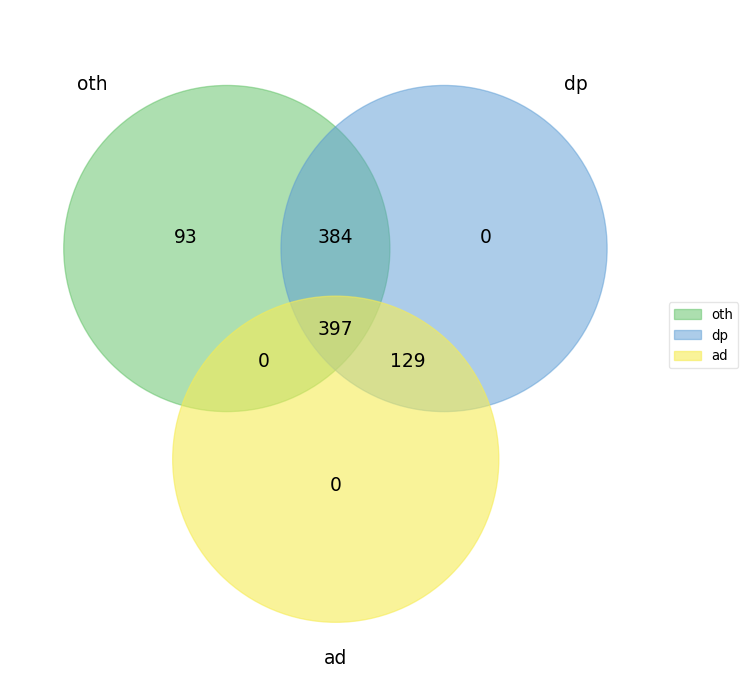

In [18]:
# print(ad_l[ind]["Variant"].max())
# print(len(set(ad_l[ind]["Variant"])))

# print(dp_l[ind]["Variant"].max())
# print(len(set(dp_l[ind]["Variant"])))

# print(oth_l[ind]["Variant"].max())
# print(len(set(oth_l[ind]["Variant"])))
#from matplotlib.pyplot as plt
from src.external.pyvenn import venn

%matplotlib inline
labels = venn.get_labels([set(oth["Variant"].values),set(dp["Variant"].values), set(ad["Variant"].values) ])
fig, ax = venn.venn3(labels, names=['oth', 'dp','ad'])
print("Total number of unique Variants")
print(len(set(oth["Variant"].values).union(set(dp["Variant"].values).union(set(ad["Variant"].values)))))

print("Max int of Variant")
print("ad", ad["Variant"].max())
print("dp", dp["Variant"].max())
print("oth", oth["Variant"].max())

## Write the new files

In [19]:
# For each list of dataframes, merge and save
ad_full = pd.concat(ad_l, axis=0)
print('ad_full')
print(ad_full.head())
dp_full = pd.concat(dp_l)
oth_full = pd.concat(oth_l)

# Save the order of IDs and the cell maps

# Save the pseudo matrices
# Need to also add in a row tha is max var, max cell, number of entries
header = "%%MatrixMarket matrix coordinate integer general\n%\n"

if os.path.exists(join(outdir, "cellSNP.tag.DP.mtx")):
    os.remove(join(outdir, "cellSNP.tag.DP.mtx"))
if os.path.exists(join(outdir, "cellSNP.tag.AD.mtx")):
    os.remove(join(outdir, "cellSNP.tag.AD.mtx"))
if os.path.exists(join(outdir, "cellSNP.tag.OTH.mtx")):
    os.remove(join(outdir, "cellSNP.tag.OTH.mtx"))    

with open(join(outdir, "cellSNP.tag.AD.mtx"), 'a') as file:
    file.write(header)
    ad_full = pd.concat((pd.DataFrame({"Variant":ad_full["Variant"].max(),
                                       "Cell": ad_full["Cell"].max(),
                                       "integer": ad_full.shape[0]},
                                      index=["Meta"]),ad_full.sort_values(["Variant", "Cell"])))
    ad_full.to_csv(file, sep="\t", header=False, index=False)


                  
with open(join(outdir, "cellSNP.tag.DP.mtx"), 'a') as file:
    file.write(header)
    dp_full = pd.concat((pd.DataFrame({"Variant":dp_full["Variant"].max(),
                                     "Cell": dp_full["Cell"].max(),
                                     "integer": dp_full.shape[0]},
                                      index=["Meta"]),dp_full.sort_values(["Variant", "Cell"])))
    dp_full.to_csv(file, sep="\t", header=False, index=False)
with open(join(outdir, "cellSNP.tag.OTH.mtx"), 'a') as file:
    file.write(header)
    oth_full = pd.concat((pd.DataFrame({"Variant":oth_full["Variant"].max(),
                                        "Cell": oth_full["Cell"].max(),
                                        "integer": oth_full.shape[0]},
                                       index=["Meta"]),oth_full.sort_values(["Variant", "Cell"])))
    oth_full.to_csv(file, sep="\t", header=False, index=False)

# Save cell indices
for ind, val in enumerate(indirs):
    with open(join(outdir, f"cell_indices_{ind}.txt"), 'w') as f:
        curr = val + "\n" + "old index,new index"
        for k in cells_kept[val]:
            curr = f"{curr}\n{k},{cells_kept[val][k]}"
        f.write(curr)



# Subsampling on bam files:
# Pros: More raw
# Cons: Will subsampling on bam miss the paired reads? Can that be connected

#Subsampling on mtx files:
#Pros: Already takes care of the bam processing, and takes care of batch
# for each separately.
# @click.command()
# @click.argument("outdir", type=click.Path())
# @click.argument("indirs", type=click.Path(exists=True), nargs=-1)
# @click.option("--is_prop", default=False, type=click.BOOL)
# @click.option("--num_cells", default=1000)
# def main(outdir, indirs, is_prop, num_cells):
#     subsample_sparse_matrices(outdir, indirs,
#                               num_cells_total=num_cells,
#                               is_proportional=is_prop,
#                               cell_subsample=0.1)
#     return


# if __name__ == "__main__":
# #    main()
#     os.chdir("/data2/mito_lineage/Analysis/multiplex")
#     main(["data/vireo/pseudo/numC1000_ispropFalse",
#          "data/PBMC_J_cellSNP", "data/PBMC_P_cellSNP",
#          '--num_cells', 1000, '--is_prop', False])


ad_full
   Variant  Cell  integer
1        1    20        2
2        1    32        2
3        1    86        2
4        1    93        1
5        1   134        2


In [20]:
print(max(ad_full.iloc[1:]["Cell"]))
print(len(set(ad_full.iloc[1:]["Cell"])))
print(max(ad_full.iloc[1:]["Variant"]))

1421
1269
1878


In [21]:
# os.chdir("/data2/mito_lineage/Analysis/multiplex")
# main(["data/vireo/pseudo/numC1000_ispropFalse",
#      "data/PBMC_J_cellSNP", "data/PBMC_P_cellSNP",
#      '--num_cells', 1000, '--is_prop', False])
